In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=12)  # Set the default font size
plt.rc('font', family='Times New Roman')
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
import pyimfit
print(pyimfit.__file__)


/Users/ainsleylewis/Library/Python/3.11/lib/python/site-packages/pyimfit/__init__.py


In [2]:
image_file = "Rommulus_Mock_i2_SNIa_z1_cusp.fits"
hdu_list = fits.open(image_file)
hdu_list.info()
image_data = hdu_list[0].data
hdu_list.close()

Filename: Rommulus_Mock_i2_SNIa_z1_cusp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   (125, 125)   float64   


(0.0, 125.0)

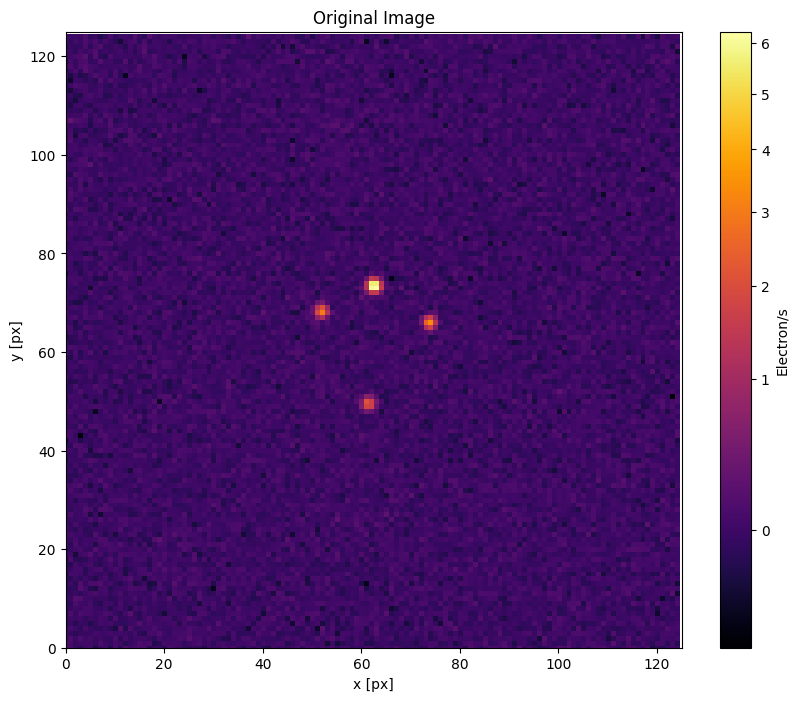

In [3]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [4]:
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
sigma_clip = SigmaClip(sigma=3.0, maxiters=20)
threshold = detect_threshold(image_data, nsigma=5.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image_data, threshold, npixels=5)
footprint = circular_footprint(radius=5)
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, mask=mask)
print(mean, median, std)

-7.474153442663751e-06 -5.1918204552634705e-05 0.06578015758988516


(0.0, 125.0)

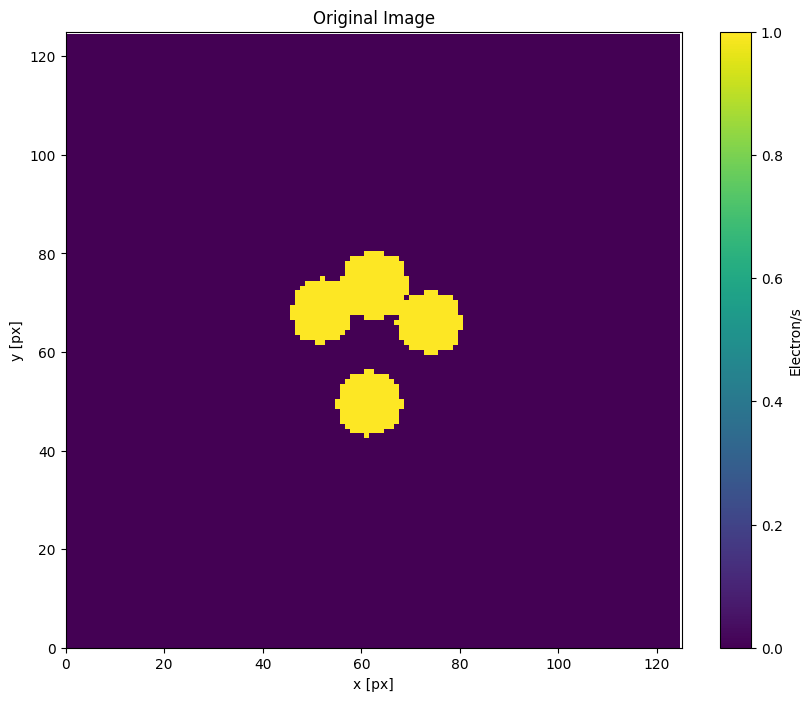

In [5]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(mask)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [6]:
image_data = image_data - median

(0.0, 125.0)

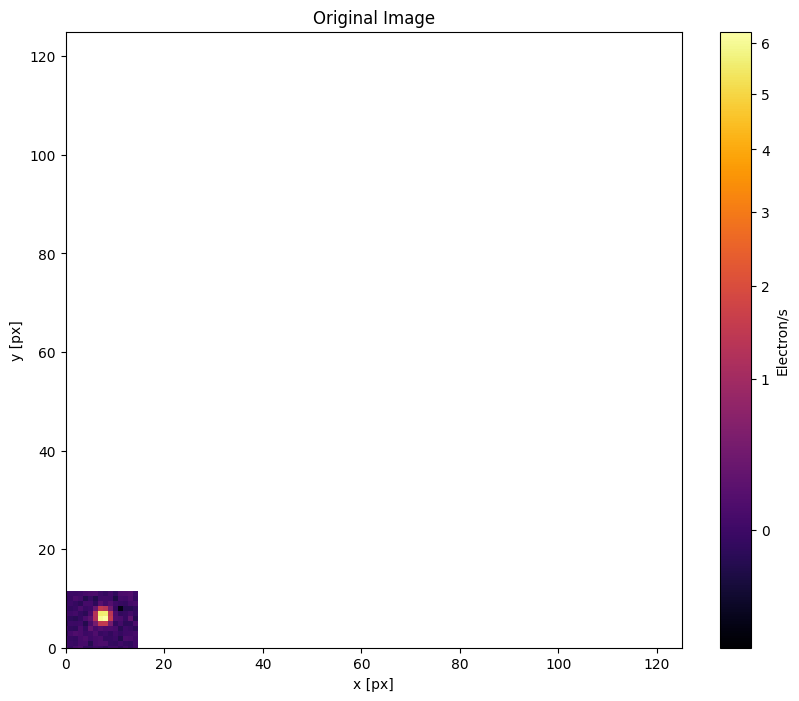

In [7]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data[67:79,55:70], cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [8]:
noise_file = "noise_map.fits"
hdu_list = fits.open(noise_file)
hdu_list.info()
noise_map = hdu_list[0].data
hdu_list.close()

Filename: noise_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (125, 125)   float64   


In [9]:
image_data = image_data * 600
image_data = image_data - noise_map

(0.0, 125.0)

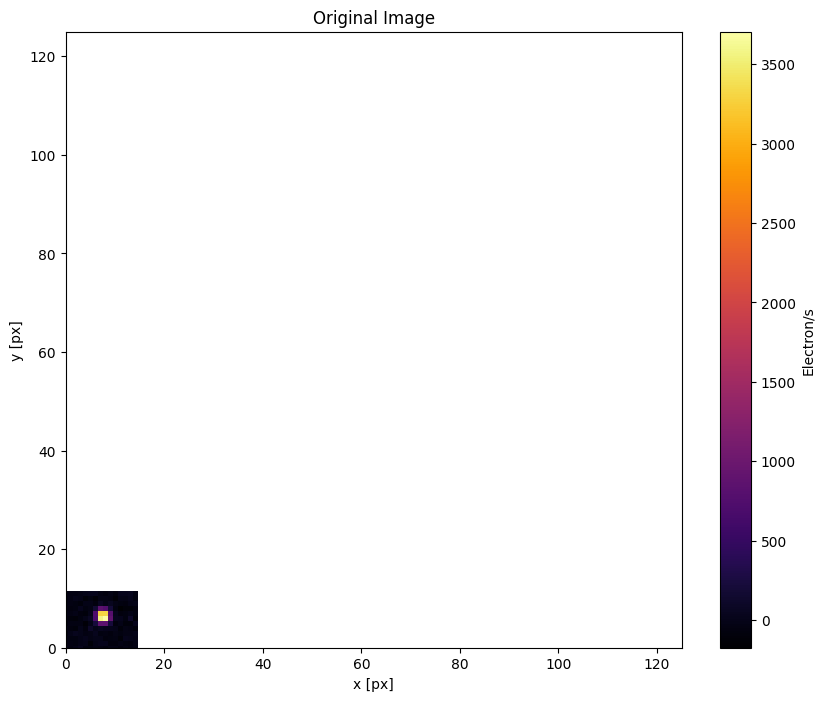

In [10]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data[67:79,55:70], cmap='inferno')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [11]:
imageFile = "Rommulus_Mock_i2_SNIa_z1_cusp.fits"
configFile = "config.dat"

model_desc = pyimfit.ModelDescription.load(configFile)

imfit_fitter = pyimfit.Imfit(model_desc)

fit_result = imfit_fitter.fit(image_data[67:79,55:70], solver='DE', verbose=2)
print(fit_result)

# check the fit and print the resulting best-fit parameter values
if imfit_fitter.fitConverged is True:
    print("Fit converged: chi^2 = {0}, reduced chi^2 = {1}".format(imfit_fitter.fitStatistic,
        imfit_fitter.reducedFitStatistic))
    print("Best-fit parameter values:")
    print(imfit_fitter.getRawParameters())

Calling Differential Evolution solver ..
            aic: 165284.75645714166
            bic: 165303.42864911404
   fitConverged: True
        fitStat: 165272.2709080087
 fitStatReduced: 949.8406374023489
     nFuncEvals: 1920
          nIter: -1
      paramErrs: None
         params: array([ 55.27124545,  70.57506476, 110.51722385,   0.57104668,
         5.31267266,   8.1645684 ])
     solverName: 'DE'
Fit converged: chi^2 = 165272.2709080087, reduced chi^2 = 949.8406374023489
Best-fit parameter values:
[ 55.27124545  70.57506476 110.51722385   0.57104668   5.31267266
   8.1645684 ]
   DESolver::Setup -- using uniform sampling.

Generation    0: bestEnergy = 165272.2709080087
Generation   10: bestEnergy = 165272.2709080087
Generation   20: bestEnergy = 165272.2709080087   (relative change = 0.000000e+00)
Generation   30: bestEnergy = 165272.2709080087   (relative change = 0.000000e+00)
Generation   40: bestEnergy = 165272.2709080087   (relative change = 0.000000e+00)

In [12]:
p_bestfit = fit_result.params

print("Best-fitting parameter values:")
for i in range(len(p_bestfit) - 1):
    print("{0:g}".format(p_bestfit[i]), end=", ")
print("{0:g}\n".format(p_bestfit[-1]))

Best-fitting parameter values:
55.2712, 70.5751, 110.517, 0.571047, 5.31267, 8.16457



In [13]:
# Posterior and Prior log probabilities
def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood

def lnPrior_limits( params, imfitter ):
    parameterLimits = imfitter.getParameterLimits()
    if None in parameterLimits:
        raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0

In [50]:
import emcee
import corner

ndims, nwalkers = 6, 100

sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))
initial_pos = [p_bestfit + 1e-4 * np.random.randn(ndims) for i in range(nwalkers)]
sampler.run_mcmc(initial_pos, 1000)

State([[6.26255464e+01 7.82498572e+01 1.02438329e+02 9.85062511e-01
  3.43992651e+01 1.98089751e+01]
 [6.80280462e+01 7.14215360e+01 6.77052045e+01 7.49041467e-01
  6.70218784e+00 2.41190635e+01]
 [6.97217878e+01 7.39549694e+01 3.55631896e+01 7.64341127e-01
  1.61324374e+01 2.35525089e+00]
 [6.21803723e+01 7.88589023e+01 9.14660673e+01 2.54096217e-01
  3.11570401e+01 3.31699251e+00]
 [6.12722455e+01 6.83936758e+01 2.55129798e+01 7.44042868e-01
  1.94645490e+01 4.66431047e+01]
 [6.50838607e+01 7.41232096e+01 1.57785891e+02 3.28905680e-01
  8.28641352e+01 5.76726989e+00]
 [5.69200891e+01 7.49546580e+01 1.50558970e+01 8.78121589e-01
  7.86975853e+01 2.04077858e+01]
 [6.58618770e+01 7.30074119e+01 1.39026089e+01 9.82893873e-01
  4.64654769e+01 1.25259524e+01]
 [6.18767436e+01 7.76054501e+01 1.77290334e+02 6.31898230e-01
  7.51083380e+01 2.75800357e+00]
 [6.63282195e+01 7.72733715e+01 1.42593178e+02 4.01077757e-01
  3.85323180e+01 2.12384228e+00]
 [6.49699486e+01 7.09156110e+01 6.44996634e+

In [51]:
def PlotAllWalkers( sample_chain, parameterIndex, yAxisLabel ):
    nWalkers = sample_chain.shape[0]
    for i in range(nWalkers):
        plt.plot(sample_chain[i,:,parameterIndex], color='blue', alpha=0.3)
    plt.xlabel('Step number', fontsize=14)
    plt.ylabel(yAxisLabel, fontsize=14)

Text(0.5, 0.98, 'Parameter chains for all walkers')

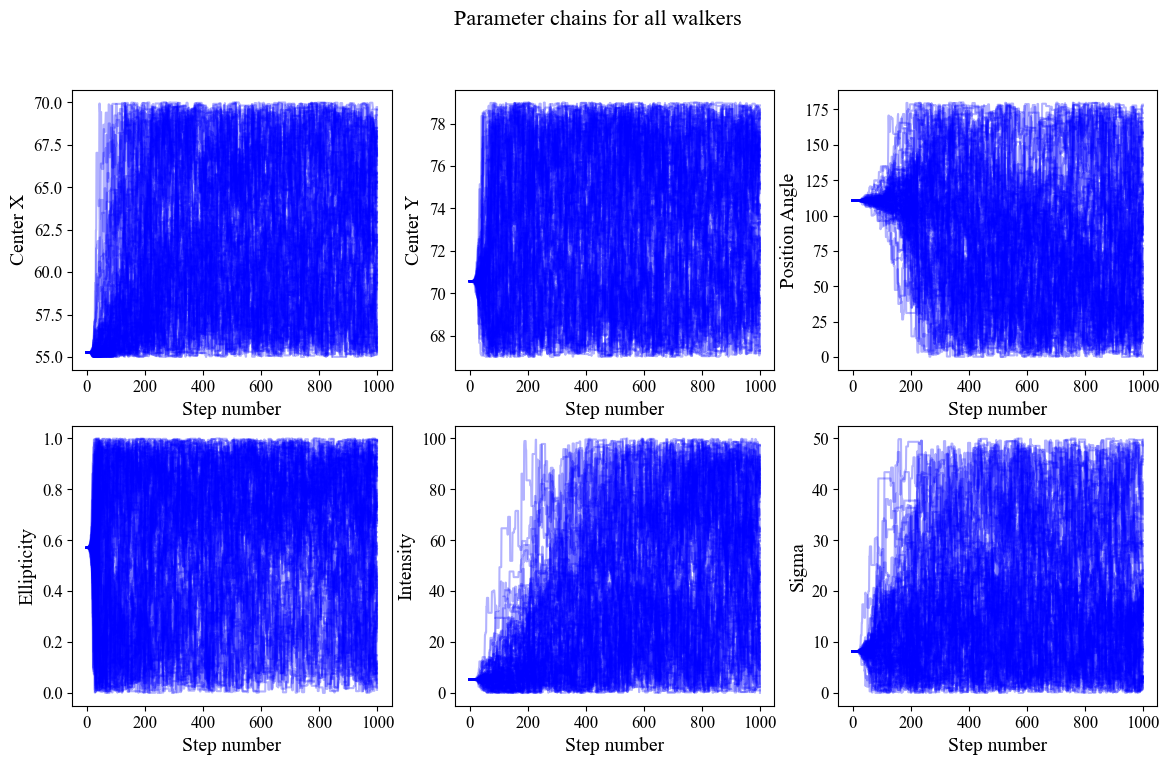

In [56]:
plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
PlotAllWalkers(sampler.chain, 0, 'Center X')
plt.subplot(2,3,2)
PlotAllWalkers(sampler.chain, 1, 'Center Y')
plt.subplot(2,3,3)
PlotAllWalkers(sampler.chain, 2, 'Position Angle')
plt.subplot(2,3,4)
PlotAllWalkers(sampler.chain, 3, 'Ellipticity')
plt.subplot(2,3,5)
PlotAllWalkers(sampler.chain, 4, 'Intensity')
plt.subplot(2,3,6)
PlotAllWalkers(sampler.chain, 5, 'Sigma')
plt.suptitle('Parameter chains for all walkers', fontsize=16)

In [53]:
converged_samples = sampler.chain[:, 500:, :].reshape((-1, ndims))
print("Number of samples in \"converged\" chain = {0}".format(len(converged_samples)))

Number of samples in "converged" chain = 50000


In [54]:
cornerLabels = [r"$X_{0}$", r"$Y_{0}$", "PA", "ell", r"$I_{0}$", r"$\sigma$"]

x0_range = (55,70)
y0_range = (67,79)
pa_range = (0,180)
ell_range = (0, 1)
i0_range = (0,50)
sigma_range = (0,5)
ranges = [x0_range, y0_range, pa_range, ell_range, i0_range, sigma_range]

Text(0.5, 0.98, 'Corner Plot (Gaussian Fit, 100 Walkers over 1000 Steps)')

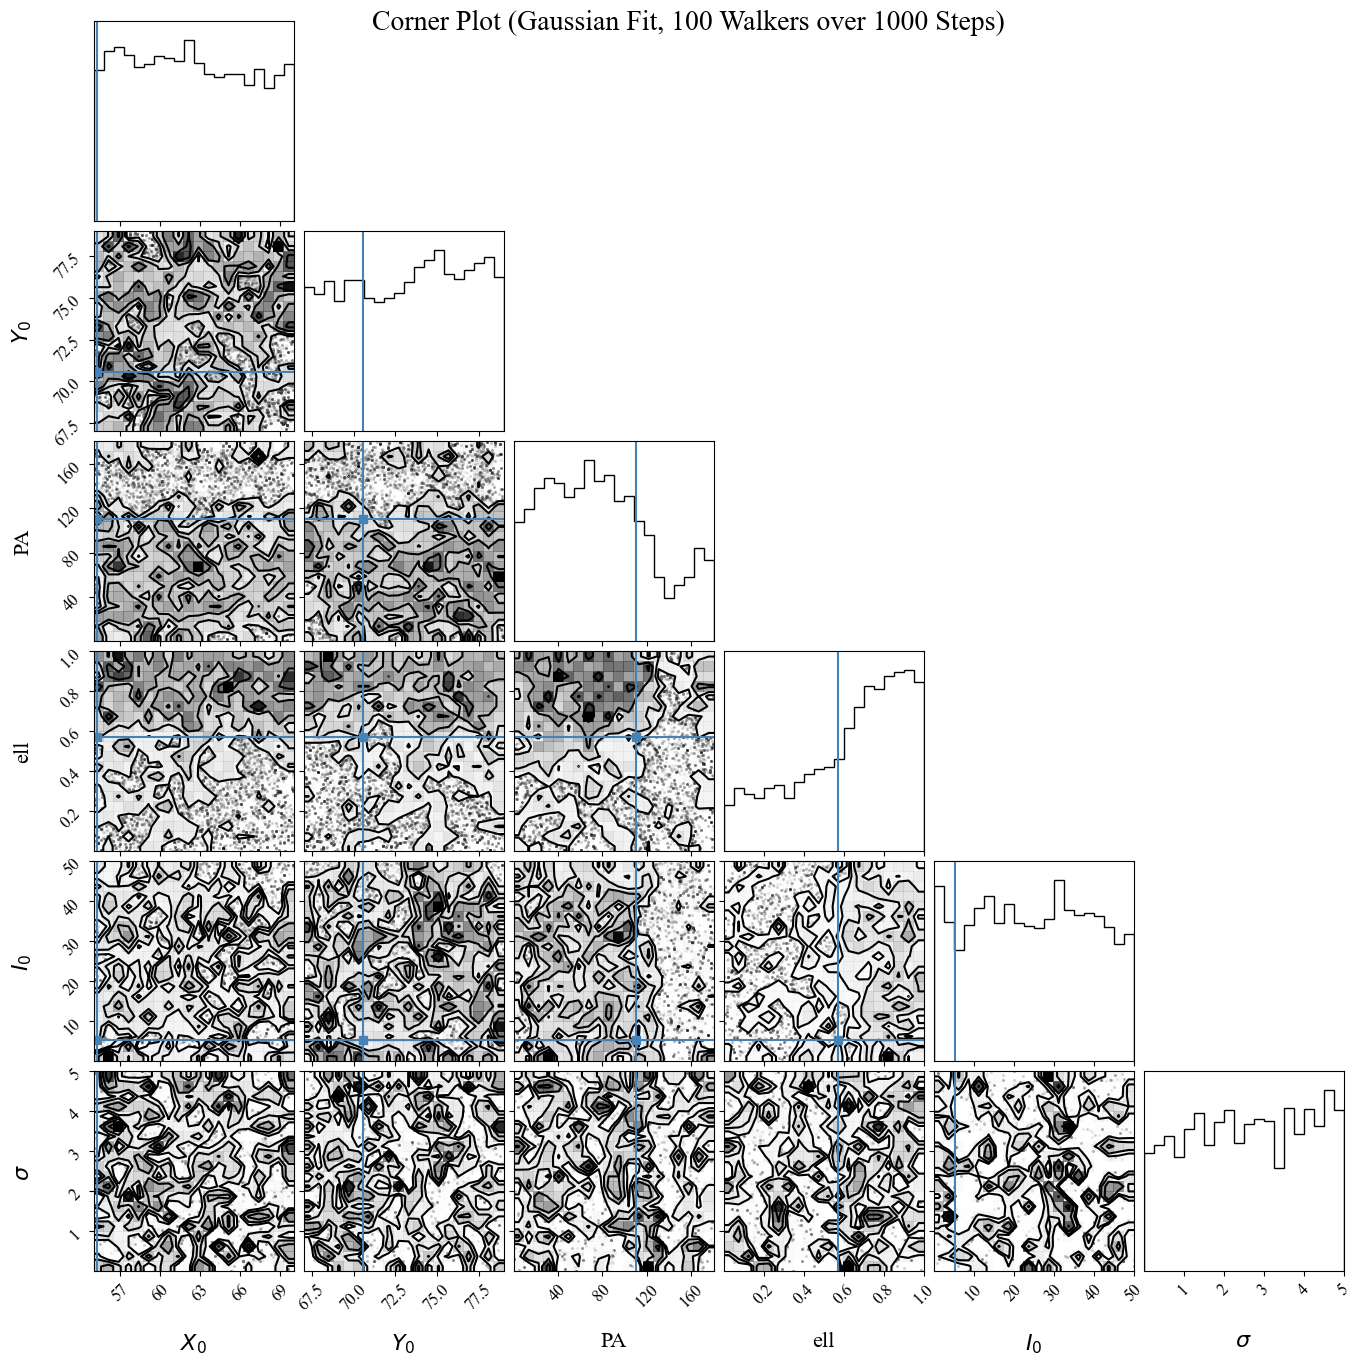

In [55]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
fig = corner.corner(converged_samples, labels=cornerLabels, range=ranges, truths=p_bestfit)
plt.suptitle('Corner Plot (Gaussian Fit, 100 Walkers over 1000 Steps)', fontsize=20)